### 第4章画像分類（その4）
#### 精度向上のテクニック

In [1]:
from collections import deque
import copy
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as T

from src import utils, model

In [2]:
# パラメータ初期化の追加
"""
パラメータ初期化関数
"""
def _reset_parameters(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            # Heらが提案した正規分布を使って初期化
            nn.init.kaiming_normal_(m.weight, mode="fan_in",
                                    nonlinearity="relu")

In [3]:
# ResNet18の実装
class ResNet18(nn.Module):
    """
    ResNet18モデル
    num_classes : 分類対象の物体モデル数
    """
    def __init__(self, num_classes: int):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = nn.Sequential(
            model.BasicBlock(64, 64),
            model.BasicBlock(64, 64),
        )
        self.layer2 = nn.Sequential(
            model.BasicBlock(64, 128, stride=2),
            model.BasicBlock(128, 128),
        )
        self.layer3 = nn.Sequential(
            model.BasicBlock(128, 256, stride=2),
            model.BasicBlock(256, 256),
        )
        self.layer4 = nn.Sequential(
            model.BasicBlock(256, 512, stride=2),
            model.BasicBlock(512, 512),
        )
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # ドロップアウトの追加
        self.dropout = nn.Dropout()
        
        self.linear = nn.Linear(512, num_classes)
        
        self._reset_parameters()
    
    """
    パラメータの初期化関数
    """
    def _reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Heらが考案した正規分布を使って初期化
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                                        nonlinearity='relu')
    
    """
    順伝播関数
    x            : 入力, [バッチサイズ, 入力チャネル数, 高さ, 幅]
    return_embed : 特徴量を返すかロジットを返すかを選択する真偽値
    """
    def forward(self, x: torch.Tensor, return_embed: bool=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = x.flatten(1)
        
        if return_embed:
            return x
        
        x = self.dropout(x)
        
        x = self.linear(x)
        
        return x
    
    """
    モデルパラメータが保存されているデバイスを返す関数
    """
    def get_device(self):
        return self.linear.weight.device
    
    """
    モデルを複製して返す関数
    """
    def copy(self):
        return copy.deepcopy(self)

In [4]:
class Config:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        self.val_ratio = 0.2   # 検証に使う学習セット内のデータの割合
        self.num_epochs = 30   # 学習エポック数
        self.lr_drop = 25      # 学習率を減衰させるエポック
        self.lr = 1e-2         # 学習率
        self.moving_avg = 20   # 移動平均で計算する損失と正確度の値の数
        self.batch_size = 32   # バッチサイズ
        self.num_workers = 2   # データローダに使うCPUプロセスの数
        self.device = 'cuda'   # 学習に使うデバイス
        self.num_samples = 200 # t-SNEでプロットするサンプル数

In [5]:
# 学習・評価を行う関数
def train_eval():
    config = Config()
    
    # 入力データ正規化のために学習セットのデータを使って
    # 各チャネルの平均と標準偏差を計算
    dataset = torchvision.datasets.CIFAR10(
        root="../chapter3-data/", train=True, download=True,
        transform=T.ToTensor()
    )
    channel_mean, channel_std = utils.get_dataset_statistics(dataset)
    
    # 画像の整形を行うクラスのインスタンスを用意
    train_transforms = T.Compose((
        T.RandomResizedCrop(32, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=channel_mean, std=channel_std),
    ))
    test_transforms = T.Compose((
        T.ToTensor(),
        T.Normalize(mean=channel_mean, std=channel_std),
    ))
    
    # 学習、評価セットの用意
    train_dataset = torchvision.datasets.CIFAR10(
        root="../chapter3-data/", train=True, download=True,
        transform=train_transforms,
    )
    val_dataset = torchvision.datasets.CIFAR10(
        root="../chapter3-data/", train=True, download=True,
        transform=test_transforms,
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root="../chapter3-data/", train=False, download=True,
        transform=test_transforms,
    )
    
    # 学習・検証セットへ分割するためのインデックス集合の生成
    val_set, train_set = utils.generate_subset(
        train_dataset, config.val_ratio
    )
    
    print(f'学習セットのサンプル数: {len(train_set)}')
    print(f'検証セットのサンプル数: {len(val_set)}')
    print(f'テストセットのサンプル数: {len(test_dataset)}')
    
    # インデックス集合から無作為にインデックスをサンプルするサンプラー
    train_sampler = SubsetRandomSampler(train_set)
    
    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set
    )
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers
    )
    
    # 目的関数の生成
    loss_func = F.cross_entropy
    
    # 検証セットの結果による最良モデルの保存変数
    val_loss_best = float('inf')
    model_best = None
    
    # ResNet18モデルの生成
    model = ResNet18(len(train_dataset.classes))
    
    # モデルを指定デバイスに転送
    model.to(config.device)
    
    # 最適化器の生成
    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=0.9, weight_decay=1e-5)
    
    # 学習率減衰を管理するスケジューラの生成
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[config.lr_drop], gamma=0.1
    )
    
    for epoch in range(config.num_epochs):
        model.train()
        
        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch+1}]')
            
            # 移動平均計算用
            losses = deque()
            accs = deque()
            for x, y in pbar:
                x = x.to(model.get_device())
                y = y.to(model.get_device())
                
                # パラメータの勾配をリセット
                optimizer.zero_grad()
                
                # 順伝播
                y_pred = model(x)
                
                # 学習データに対する損失と正確度を計算
                loss = loss_func(y_pred, y)
                accuracy = (y_pred.argmax(dim=1) == y).float().mean()
                
                # 誤差逆伝播
                loss.backward()
                
                # パラメータの更新
                optimizer.step()
                
                # 移動平均を計算して表示
                losses.append(loss.item())
                accs.append(accuracy.item())
                if len(losses) > config.moving_avg:
                    losses.popleft()
                    accs.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(losses).mean().item(),
                    'accuracy': torch.Tensor(accs).mean().item()
                })
                
        
        # 検証セットを使って精度評価
        val_loss, val_accuracy = utils.evaluate(
            val_loader, model, loss_func
        )
        print(f'検証: loss = {val_loss:.3f}, accuracy = {val_accuracy:.3f}')
        
        # より良い検証結果が得られた場合、モデルを記録
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            model_best = model.copy()
            
        # エポック終了時にスケジューラ更新
        scheduler.step()
        
    # テスト
    test_loss, test_accuracy = utils.evaluate(
        test_loader, model_best, loss_func
    )
    print(f'テスト: loss = {test_loss:.3f}, accuracy = {test_accuracy:.3f}')
    
    # t-SNEを使用して特徴量の分布をプロット
    utils.plot_t_sne(test_loader, model_best, config.num_samples)
    
    # モデルパラメータを保存
    torch.save(model_best.state_dict(), 'ResNet18.pth')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数: 40000
検証セットのサンプル数: 10000
テストセットのサンプル数: 10000


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 2.689, accuracy = 0.339


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 1.510, accuracy = 0.510


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 1.183, accuracy = 0.579


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 1.079, accuracy = 0.628


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 1.161, accuracy = 0.620


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.915, accuracy = 0.679


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.957, accuracy = 0.681


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.824, accuracy = 0.716


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.867, accuracy = 0.709


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.803, accuracy = 0.725


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.738, accuracy = 0.741


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.721, accuracy = 0.752


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.788, accuracy = 0.741


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.738, accuracy = 0.761


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.745, accuracy = 0.758


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.702, accuracy = 0.765


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.652, accuracy = 0.783


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.712, accuracy = 0.763


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.656, accuracy = 0.780


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.676, accuracy = 0.773


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.668, accuracy = 0.779


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.655, accuracy = 0.785


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.677, accuracy = 0.780


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.649, accuracy = 0.787


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.654, accuracy = 0.784


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.610, accuracy = 0.805


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.595, accuracy = 0.813


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.601, accuracy = 0.813


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.604, accuracy = 0.812


  0%|          | 0/1250 [00:00<?, ?it/s]

検証: loss = 0.643, accuracy = 0.810
テスト: loss = 0.646, accuracy = 0.796


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


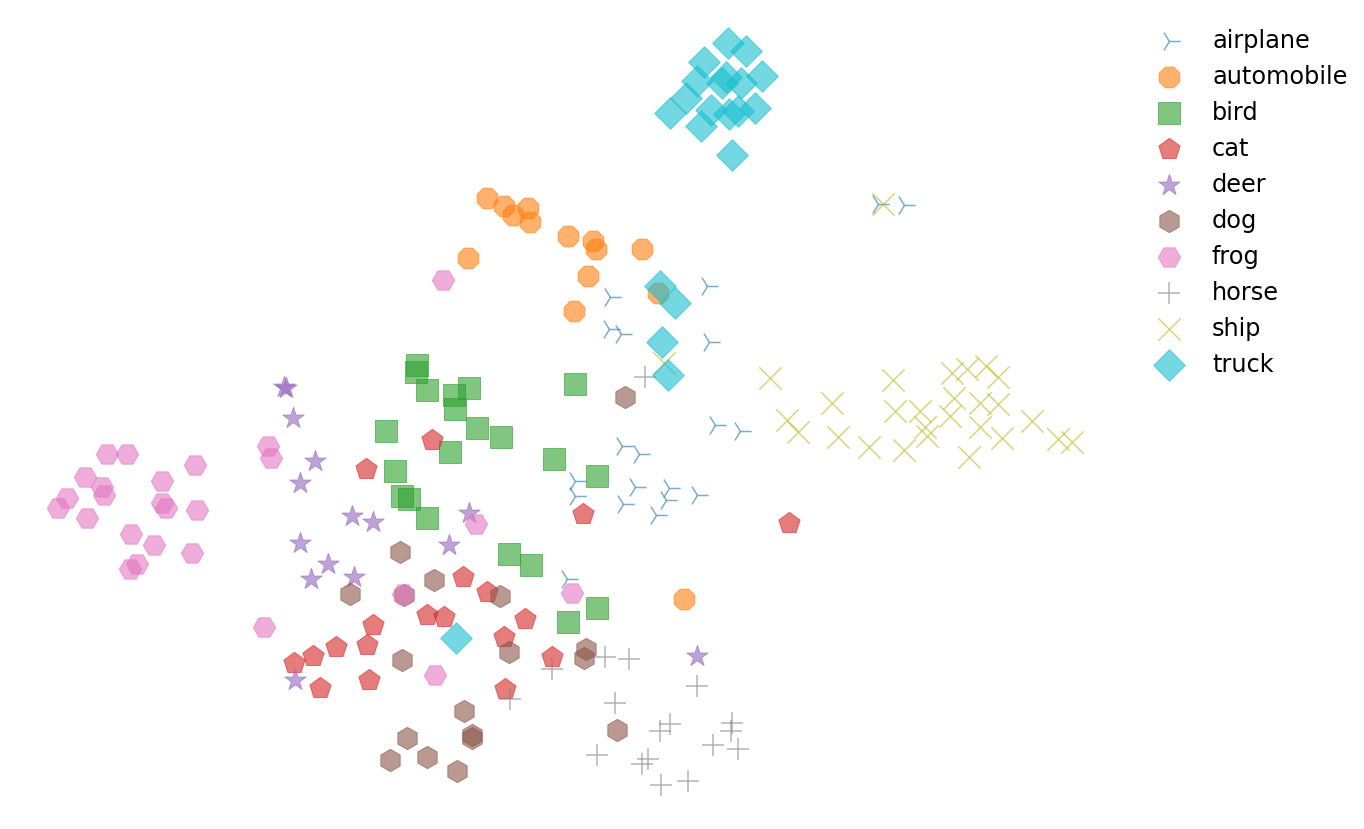

In [6]:
train_eval()

In [7]:
# pip install ipywidgets

In [8]:
# デモ関数
def demo():
    config = Config()
    
    # 入力チャネル正規化のための学習データを使って
    # 各チャネルの平均と標準偏差を計算
    dataset = torchvision.datasets.CIFAR10(
        root="../chapter3-data/", train=True, download=True,
        transform=T.ToTensor(),
    )
    channel_mean, channel_std = utils.get_dataset_statistics(dataset)
    
    transforms = T.Compose((
        T.ToTensor(),
        T.Normalize(mean=channel_mean, std=channel_std),
    ))
    
    # ResNet18モデルの生成とパラメータの読み込み
    model = ResNet18(len(dataset.classes))
    model.load_state_dict(torch.load('ResNet18.pth'))
    
    # モデルを指定のデバイスに転送
    model.to(config.device)
    
    # 推論モード
    model.eval()
    
    for img_path in Path("../data/classification/").glob('*.jpg'):
        img = Image.open(img_path)
        display(img.resize((256, 256)))
        
        # 画像を整形
        img = transforms(img)
        
        # バッチ軸の追加
        img = img.unsqueeze(0)
        
        img = img.to(config.device)
        
        pred = model(img)
        
        # 数値表現の予測ラベルを取得
        pred = pred[0].argmax()
        
        print(f'予測: {dataset.classes[pred]}, 正解: {img_path.stem}')
        

Files already downloaded and verified


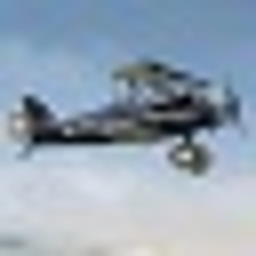

予測: airplane, 正解: airplane


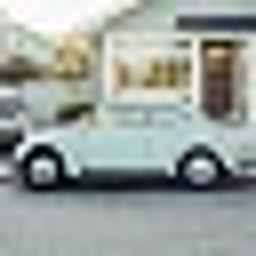

予測: automobile, 正解: automobile


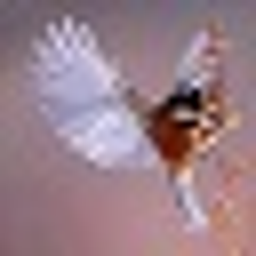

予測: airplane, 正解: bird


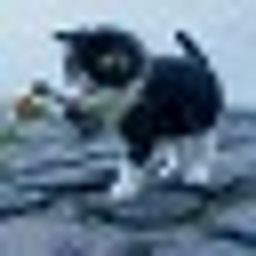

予測: airplane, 正解: cat


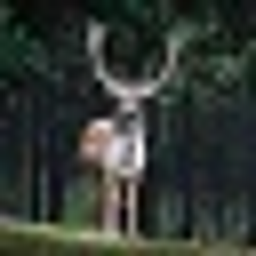

予測: deer, 正解: deer


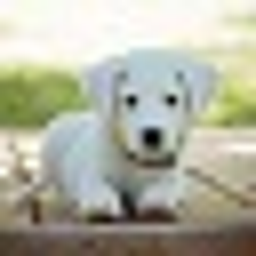

予測: airplane, 正解: dog


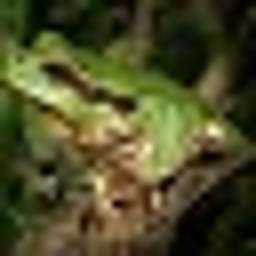

予測: frog, 正解: frog


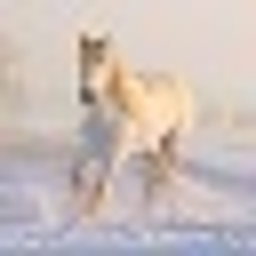

予測: dog, 正解: horse


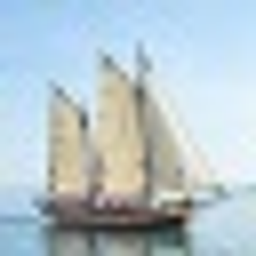

予測: ship, 正解: ship


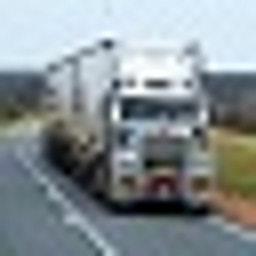

予測: truck, 正解: truck


In [10]:
# デモ実行
demo()